# Predicting House Sale Prices Using A Simple Linear Regression

In this project, I will be working with housing data for the city of Ames, Iowa, United States from 2006 to 2010. The dataset was originally compiled by Dean De Cock for the primary purpose of having a high quality dataset for regression. His paper can be found [here](https://www.tandfonline.com/doi/abs/10.1080/10691898.2011.11889627) 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
import seaborn as sns
%matplotlib inline

In [2]:
house=pd.read_csv('AmesHousing.tsv',sep='\t')

In [3]:
print(house.head())
print('\n')
print(house.info())

   Order        PID  MS SubClass MS Zoning  Lot Frontage  Lot Area Street  \
0      1  526301100           20        RL         141.0     31770   Pave   
1      2  526350040           20        RH          80.0     11622   Pave   
2      3  526351010           20        RL          81.0     14267   Pave   
3      4  526353030           20        RL          93.0     11160   Pave   
4      5  527105010           60        RL          74.0     13830   Pave   

  Alley Lot Shape Land Contour  ... Pool Area Pool QC  Fence Misc Feature  \
0   NaN       IR1          Lvl  ...         0     NaN    NaN          NaN   
1   NaN       Reg          Lvl  ...         0     NaN  MnPrv          NaN   
2   NaN       IR1          Lvl  ...         0     NaN    NaN         Gar2   
3   NaN       Reg          Lvl  ...         0     NaN    NaN          NaN   
4   NaN       IR1          Lvl  ...         0     NaN  MnPrv          NaN   

  Misc Val Mo Sold Yr Sold Sale Type  Sale Condition  SalePrice  
0       

## Data Cleaning

In [4]:
data_clean=house.copy()

# Drop columns with more than 5% missing observations
data_clean.dropna(thresh=0.95*house.shape[0],axis=1,inplace=True)

# Fill missing values with the mean for numerical columns and with the most common value for categorical columns
data_clean.fillna(data_clean.mean(),inplace=True)
data_clean.fillna(data_clean.mode().iloc[0],inplace=True)

# Create new features
data_clean['years_sold']=data_clean['Yr Sold']-data_clean['Year Built']
data_clean['years_since_remod']=data_clean['Yr Sold']-data_clean['Year Remod/Add']

# Drop rows with negative values
rows_drop=data_clean[(data_clean['years_since_remod']<0) |(data_clean['years_sold']<0)].index
data_clean.drop(rows_drop,inplace=True)

# Drop columns that aren't useful
columns_drop=["PID", "Order", "Mo Sold", "Sale Condition", "Sale Type", "Year Built", "Year Remod/Add"]
data_clean.drop(columns_drop,axis=1,inplace=True)

## Features Selection

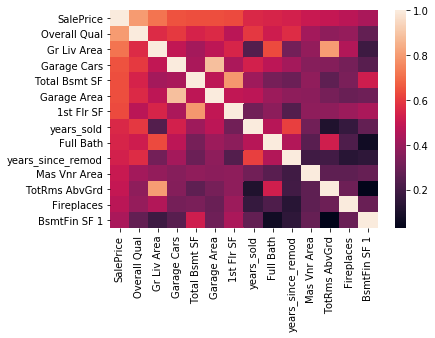

In [5]:
numerical_cols=data_clean.select_dtypes(include=['int64','float']).columns
text_cols=data_clean.select_dtypes(include=['object']).columns

# Calculate correlations then pick features with a strong correlation with SalePrice
correlations=data_clean[numerical_cols].corr()['SalePrice'].abs().sort_values(ascending=False)
strong_num_features=correlations[correlations>0.4].index

# Generate a heatmap for better visual:
sns.heatmap(data_clean[strong_num_features].corr().abs())
# It seems that a couple of feature pairs are highly correlated, which makes sense:
# ('Gr Liv Area' and 'TotRms AbvGrd'), ('Garage Area' and 'Garage Cars'), ('1st Flr SF' and 'Total Bsmt SF')

# A solution is to only include either feature of each pair
strong_num_features=strong_num_features.drop(['TotRms AbvGrd','Garage Cars','Total Bsmt SF'])

In [6]:
# Check unique values for each categorical columns 
# Include only columns with less than 10 unique values
cat_features=[]
for col in data_clean[text_cols].columns:
    if data_clean[col].nunique()<10:
        cat_features.append(col)  

strong_cat_features=[]
for col in cat_features:
    if data_clean[col].value_counts().max()<data_clean.shape[0]*0.9:
        strong_cat_features.append(col)

# Generate dummies for categorical features
dummies_df=pd.get_dummies(data_clean[strong_cat_features])
data_clean=pd.concat([data_clean[strong_num_features],dummies_df],axis=1)

## Simple Cross Validation

In [7]:
def train_and_test(data,features,k=0):
    select_features=features.drop('SalePrice')
    lr=LinearRegression()
    
    # Split the data in two halfs, then fit the OLS regression with the train data
    # Calculate RMSE using the test data
    if k==0:
        train=data.iloc[:1460]
        test=data.iloc[1460:]
        train_features=train[select_features]
        test_features=test[select_features]
        train_target=train['SalePrice']
        test_target=test['SalePrice']
        lr.fit(train_features,train_target)
        predictions=lr.predict(test_features)
        rmse=mean_squared_error(test_target,predictions)**(1/2)
        return rmse
    
    # Split the data in two halfs, use both train and test data sets to fit and calculate RMSEs
    # Return the average of the two RMSEs
    if k == 1:
        # Randomize *all* rows (frac=1) from data and return
        shuffled_df = data.sample(frac=1, )
        train=data.iloc[:1460]
        test=data.iloc[1460:]
        train_features=train[select_features]
        test_features=test[select_features]
        train_target=train['SalePrice']
        test_target=test['SalePrice']
        lr.fit(train_features,train_target)
        predictions_1=lr.predict(test_features)
        rmse_1=mean_squared_error(test_target,predictions_1)**(1/2)
        lr.fit(test_features,test_target)
        predictions_2=lr.predict(train_features)
        rmse_2=mean_squared_error(train_target,predictions_2)**(1/2)
        return np.mean([rmse_1,rmse_2])

    # Implement k-fold cross validation
    if k>1:
        kf=KFold(n_splits=k,shuffle=True)
        rmses=[]
        for train_index,test_index in kf.split(data):
            train_features=data[select_features].iloc[train_index]
            train_target=data['SalePrice'].iloc[train_index]
            test_features=data[select_features].iloc[test_index]
            test_target=data['SalePrice'].iloc[test_index]
            lr.fit(train_features,train_target)
            predictions=lr.predict(test_features)
            rmse=mean_squared_error(test_target,predictions)**(1/2)
            rmses.append(rmse)
        avg_rmse=np.mean(rmses)
        return avg_rmse
      

In [8]:
# Select only numeric columns to fit the model
train_and_test(data_clean,strong_num_features,k=10)

32524.464688100805

In [9]:
# Select numeric and categorical features to fit the model
# The RMSE is smaller compared to using only numeric features
num_cat_features=data_clean.columns
train_and_test(data_clean,num_cat_features,k=10)

27459.21931524574